In [4]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from smart_open import smart_open
# nltk.download('stopwords')  # run once
from nltk.corpus import stopwords
# stop_words = stopwords.words('english')
from gensim import corpora
from pprint import pprint
from pyclustering.cluster.kmedians import kmedians
from pyclustering.cluster import cluster_visualizer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import FCPS_SAMPLES
# from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='notebook',
#              ticks=True, grid=False)
import math
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
# from jupyterthemes import jtplot
import operator
import pandas as pd
# nltk.download('punkt')
# jtplot.style(theme='monokai', context='notebook',
#              ticks=True, grid=False)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [5]:
df= pd.read_csv("final_clustering_df.csv")
X = np.asarray(df.iloc[:,[1,2]])

In [186]:
def random_medians(dat, num_clusters):    #Function to generate random medians
    index = np.random.randint(0, (len(dat)-1), size=num_clusters)
    points = dat[index]
    return points

def euclidean_distance(dat, rand_medians):  #Used to calculate a euclidean distance between the medians and the observations 
    X = dat
    dist_list = []
    for i in range(len(rand_medians)):
        summation = np.sum((X-rand_medians[i])**2, axis=1)
        dist_list.append(np.sqrt(summation))
    dist_list = np.asarray(dist_list)
    return (dist_list)

def euclidean_distance_word(dat, rand_medians,word_sim): #used to calculate euclidean distance + similarity between observations 
    dist_list = []
    for i in range(len(rand_medians)):
        summation = np.sum((X-rand_medians[i])**2, axis=1)
        summation = normalize(summation.reshape(-1,1)) #euclidean distance is normalized to help converge with the word similarity score
        summation = summation + (1-word_sim).reshape(-1,1) #1-similarity is done to make the similarity matrix into a ditance matrix
#         summation = word_sim
        dist_list.append(np.sqrt(summation))
    dist_list = np.asarray(dist_list)
    return (dist_list)

def assign_obsto_clusters(dat, dist_list): #compares observations and identifies which cluster is it closest to
    clusters = []
    assigned_clusters = np.argmin(dist_list, axis=0)
    for i in range(len(dist_list)):
        clusters.append(dat[assigned_clusters == i])
#     clusters = np.asarray(clusters)
    return (clusters)

def centroid_cal(assigned_clusters): #centroid calculation
    centroid = []
    for i in range(len(assigned_clusters)):
        clust= assigned_clusters[i]
        x,y = np.median(clust,axis=0)
        centroid.append((x,y))
    centroid = np.asarray(centroid)
    return (centroid)

def clust_index_find (assigned_clusters,data): #indexes retrieval of observations in the cluster
    clust_index=[]
    X = data
    for i in range(len(assigned_clusters)):
        values = np.where((X==assigned_clusters[i][:,None]).all(-1))[1]
        clust_index.append(values)
    return (clust_index)
        
def plot_clusters(assigned_clusters,centroid_old):
    color = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    for i in range(len(assigned_clusters)):
        clust = assigned_clusters[i]
        plt.scatter(clust[:,0],clust[:,1],color=RS[i])
        plt.scatter(centroid_old[i,0],centroid_old[i,1],color=color[i],
                    label=i, marker='p', s=100, edgecolor='k')
    plt.show()

def sse_calc(data,indexes): #calculation of Total SSE
    df = data
    index1 = indexes
    index_list = []
    for i in range(len(index1)):
        index_list.append(np.asarray(df.iloc[index1[i],[1,2]]))
    centers = centroid_cal(index_list)
    sse_list=[]
    for i in range(len(index1)):
        sse_list.append(np.sum(np.sum((centers[i]-index_list[i])**2,axis=1)))
    return (np.sum(sse_list))


def k_median(data,nc): #compilation of K-median
    X=data
    rand_medians = random_medians(X,num_clusters=nc)
    centroid_old = rand_medians
    dist_array = euclidean_distance(X,rand_medians)
    assigned_clusters = assign_obsto_clusters(X,dist_array)
    clust_index = clust_index_find(assigned_clusters,X)
    centroids = centroid_cal(assigned_clusters)
    i=1
    while(np.any(centroid_old != centroids)):
        centroid_old = centroids
        dist_array = euclidean_distance(X,centroid_old)
        assigned_clusters = assign_obsto_clusters(X,dist_array)
        clust_index = clust_index_find(assigned_clusters,X)
        centroids = centroid_cal(assigned_clusters)
        i=i+1        
#         print ("old=",centroid_old ,"new=",centroids)
    return (clust_index)

def similar_prod(item,no_item,data): #gives results for similar products for the requested product from the clusters
    user = []
    X = np.asarray(data.iloc[:,[1,2]])
    user.append(X[item])
    wordsim = word_sim_calc(data,item)
    dist_array = euclidean_distance_word(X,user,wordsim)
    dict = { i : dist_array[:,i] for i in range(0, dist_array.shape[1] ) }
    sorted_dict = sorted(dict.items(), key=operator.itemgetter(1))
    similar_prod_index = sorted_dict[0:(no_item+1)]
    return (df.iloc[np.asarray(similar_prod_index)[:,0]])

In [4]:
def word_sim_calc(df,item): # calculation of word vectors
    file_docs = []
    for i in range(len(df)):
        tokens = sent_tokenize(df['Names'][i])
        file_docs.append(tokens)
    mydict = corpora.Dictionary([simple_preprocess((" ".join(line))) for line in file_docs]) #making dictionary from the document
    corpus = [mydict.doc2bow(simple_preprocess((" ".join(line)))) for line in file_docs]
    tfidf = gensim.models.TfidfModel(corpus) #generation of TFIDF vector

    workdir = r'C:\Users\potd0000\\OneDrive - University of Oklahoma\Subjects\Data Mining\Project\ '
    sims = gensim.similarities.Similarity(workdir,tfidf[corpus],num_features=len(mydict)) #word similarity matrix
    query_doc_tf_idf = tfidf[corpus[item]]

    word_sim = sims[query_doc_tf_idf] 
    return (word_sim)

In [14]:
ind = int(input("Select product index : ") )
num = int(input("Select no of similar products : ") )
result = similar_prod(ind,num,df)
result

Select product index : 52
Select no of similar products : 5


,Names,Price,Rating
52,Spider-Man Colouring Fun,21.741747,0.0
2947,LEGO Juniors 10665: Spider-Man Spider-Car Pursuit,21.741747,0.0
19092,Nendoroid - The Amazing Spider-Man: Spider-Man...,21.741747,0.0
8241,Hot Wheels Amazing Spider-Man 2 Diecast Car - ...,21.741747,0.0
1022,Hot Wheels Amazing Spider-Man 2 Diecast Car - ...,21.741747,0.0
16955,"Procos 81531- ""Happy Birthday"" Ultimate Spider...",21.741747,0.0


In [188]:
# X2 = X[0:20000,:]
index = k_median(X,4)
index1 = np.asarray(index)
for i in range(4):
    index1[i] = np.unique(index1[i])
index1

array([array([    3,     6,     8, ..., 20231, 20234, 20240], dtype=int64),
       array([    2,    22,    31, ..., 20232, 20233, 20237], dtype=int64),
       array([    1,     7,    10, ..., 20238, 20239, 20241], dtype=int64),
       array([    0,     4,     5, ..., 20221, 20222, 20226], dtype=int64)],
      dtype=object)

In [197]:
ind = int(input("Select product index : ") )
print("The product is:",df.iloc[ind].Names,"\npriced at:$",df.iloc[ind].Price,"\nIt has a rating of:",df.iloc[ind].Rating)
for i in range (4):
    if ((np.asarray(np.where(index1[i]==ind)).size) >0):
        print ("The product is found in cluster number:", (i+1) )
        print("The products in this cluster have the following price and ratings structures\n", 
              df.iloc[index1[i]].describe().loc[['mean','min','max']])

Select product index : 55
The product is: Inkwear Swooping Swallows Temp Tattoo. *Premium Quality Die Cut Transfers* 
priced at:$ 21.74174707892781 
It has a rating of: 0.0
The product is found in cluster number: 1
The products in this cluster have the following price and ratings structures
            Price    Rating
mean   24.840035  0.021251
min    15.360000  0.000000
max   902.000000  2.100000


In [190]:
import pickle
with open('cluster_result_median', 'wb') as f:
    pickle.dump(index1, f)

In [191]:
import pickle
with open('cluster_result_median', 'rb') as f:
     index1 = pickle.load(f)

index1

array([array([    3,     6,     8, ..., 20231, 20234, 20240], dtype=int64),
       array([    2,    22,    31, ..., 20232, 20233, 20237], dtype=int64),
       array([    1,     7,    10, ..., 20238, 20239, 20241], dtype=int64),
       array([    0,     4,     5, ..., 20221, 20222, 20226], dtype=int64)],
      dtype=object)

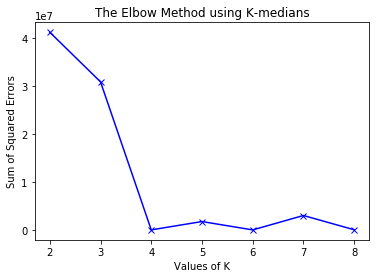

In [183]:
sse_list = []
for i in range(2,9):
    index = k_median(X,i)
    index1 = np.asarray(index)
    for j in range(i):
        index1[j] = np.unique(index1[j])
    sse_list.append(sse_calc(df,index1))
K=range(2,9)
plt.plot(K, sse_list, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Sum of Squared Errors') 
plt.title('The Elbow Method using K-medians') 
plt.show() 

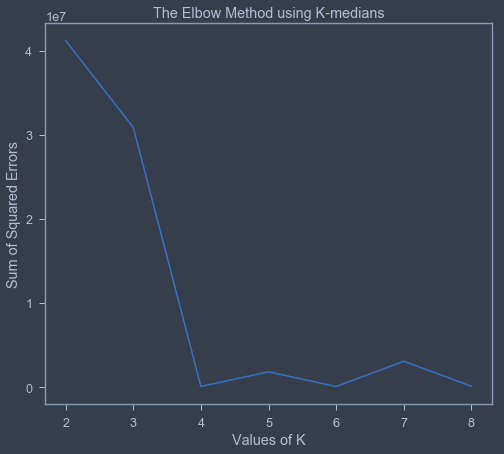

In [184]:
from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook',
             ticks=True, grid=False)
plt.plot(K, sse_list, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Sum of Squared Errors') 
plt.title('The Elbow Method using K-medians') 
plt.show() 

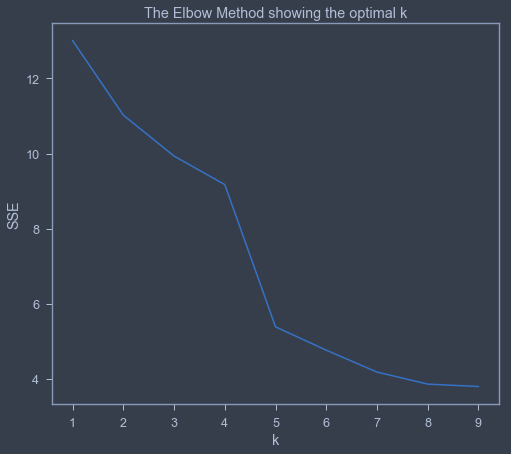

In [185]:
# create new plot and data
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook',
             ticks=True, grid=False)
plt.plot()
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

# k means determine k
sse = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    sse.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [22]:
final_clustering_df.to_csv (r'C:\Users\akhil\OneDrive - University of Oklahoma\Subjects\Data Mining\Project\final_clustering_df.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path